In [200]:
# Source reference to PyTorch official tutorial on traning a 
# classifier:
# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [201]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import time

In [198]:
# check cuda availablity
print(torch.cuda.is_available())
print(torch.cuda.device_count())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True

In [203]:
%%time
# load data CIFAR10

# transform to tensor and normalize to [-1,1]
transform = transforms.Compose(
    [transforms.Resize(256),
        transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# transform = transforms.Compose([
#         transforms.Resize(256),
#         transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
#         transforms.Normalize(
#             mean=model.original_model_info.mean,
#             std=model.original_model_info.std
#         )
#     ])
batch_size = 4
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified
Wall time: 2.17 s


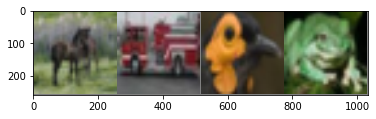

horse truck  bird  frog
Wall time: 188 ms


In [204]:
%%time
# plot some example img
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
# get some random training img
dataiter = iter(trainloader)
imges, labels = dataiter.next()

# show imgs
imshow(torchvision.utils.make_grid(imges))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [205]:
%%time
# load AlexNet pretrained model and modify the last layer to fit
# this dataset which has only 10 classes
model  = torchvision.models.alexnet(pretrained=True)

# for prarm in model.parameters():
#     prarm.requires_grad = False
    
model.classifier[6] = torch.nn.Linear(4096, 10)

Wall time: 960 ms


In [206]:
%%time
# define a loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), 
                            lr=0.001, 
                            momentum=0.9)

Wall time: 1 ms


In [207]:
%%time

def train_vali_split_loader(trainset, batch_size = 1024, num_workers=0):
    trainset_, valset_ = torch.utils.data.random_split(trainset, 
                              [int(0.8*len(trainset)), 
                               int(0.2*len(trainset))])
    
    trainloader_ = torch.utils.data.DataLoader(trainset_, 
                                              batch_size=batch_size,
                                              shuffle=True, 
                                              num_workers=0)
    
    valiloader_ = torch.utils.data.DataLoader(valset_, 
                                              batch_size=batch_size,
                                              shuffle=True, 
                                              num_workers=0)
    return (trainloader_, valiloader_)


Wall time: 0 ns


In [208]:
%%time
# train the last layer of the model, using batch size 64, 70 epochs, with cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 1024
num_workers = 6
epochs = 20
# model.to(device)

accu_train_list = []
accu_vali_list = []
for epoch in range(epochs):    # loop over the dataset multiple times
    # splite train into train and vali
    trainloader_, valiloader_ = train_vali_split_loader(trainset, 
                                                        batch_size = batch_size, 
                                                        num_workers=num_workers)
    
    running_loss = 0.0
    predicted_correct_num_train = 0
    total_train = 0
    for i, data in enumerate(trainloader_, 0):
        # get the inputs; data is a list of [inputs, labels]
#         inputs, labels = data[0].to(device), data[1].to(device)
        inputs, labels = data

        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        batch_num = 3
        running_loss += loss.item()
        if i % batch_num == batch_num-1:      # print every 5 mini-batches
            print('[%d, %5d] loss: %0.3f'%(epoch+1,batch_size*(i+1), 
                  running_loss / batch_num))
            running_loss = 0.0
        
        # training accu
        predicted_train = torch.max(outputs, 1)
        total_train += labels.size(0)
        predicted_correct_num_train += sum(predicted_train.indices == labels)
        
    accu_train = predicted_correct_num_train.item() / total_train
    accu_train_list.append(accu_train)
    
    ## detach tensor from cuda to free some space
    inputs.detach()
    labels.detach()
    
    predicted_correct_num = 0
    total_vali = 0
    # run on vali set to get accuracy
    for i, data in enumerate(valiloader_, 0):
    # get the inputs; data is a list of [inputs, labels]
#         inputs, labels = data[0].to(device), data[1].to(device)
        inputs, labels = data
        predicted_vali = torch.max(model(inputs), 1)
        
        total_vali += labels.size(0)
        predicted_correct_num += sum(predicted_vali.indices == labels)
        print("Vali {0} th batch, {1} correct, validated {2}, batch size {3}".format(i, 
                                                                      predicted_correct_num,
                                                                      batch_size*(i+1), batch_size))
        
    accu_vali = predicted_correct_num.item() / total_vali
    accu_vali_list.append(accu_vali)
    
    print("Training Accu: ", accu_train)
    print("Validation Accu: ", accu_vali)
    
print('Finish Traning')

[1,  3072] loss: 2.347
[1,  6144] loss: 2.214
[1,  9216] loss: 2.079
[1, 12288] loss: 1.863
[1, 15360] loss: 1.673
[1, 18432] loss: 1.493
[1, 21504] loss: 1.327
[1, 24576] loss: 1.241
[1, 27648] loss: 1.141
[1, 30720] loss: 1.085
[1, 33792] loss: 1.054
[1, 36864] loss: 1.027
[1, 39936] loss: 0.951
Vali 0 th batch, 694 correct, validated 1024, batch size 1024
Vali 1 th batch, 1362 correct, validated 2048, batch size 1024
Vali 2 th batch, 2047 correct, validated 3072, batch size 1024
Vali 3 th batch, 2723 correct, validated 4096, batch size 1024
Vali 4 th batch, 3367 correct, validated 5120, batch size 1024
Vali 5 th batch, 4032 correct, validated 6144, batch size 1024
Vali 6 th batch, 4696 correct, validated 7168, batch size 1024
Vali 7 th batch, 5336 correct, validated 8192, batch size 1024
Vali 8 th batch, 6000 correct, validated 9216, batch size 1024
Vali 9 th batch, 6542 correct, validated 10240, batch size 1024
Training Accu:  0.479625
Validation Accu:  0.6542
[2,  3072] loss: 0.96

Vali 2 th batch, 2548 correct, validated 3072, batch size 1024
Vali 3 th batch, 3404 correct, validated 4096, batch size 1024
Vali 4 th batch, 4268 correct, validated 5120, batch size 1024
Vali 5 th batch, 5147 correct, validated 6144, batch size 1024
Vali 6 th batch, 5992 correct, validated 7168, batch size 1024
Vali 7 th batch, 6848 correct, validated 8192, batch size 1024
Vali 8 th batch, 7701 correct, validated 9216, batch size 1024
Vali 9 th batch, 8341 correct, validated 10240, batch size 1024
Training Accu:  0.830325
Validation Accu:  0.8341
[10,  3072] loss: 0.472
[10,  6144] loss: 0.461
[10,  9216] loss: 0.483
[10, 12288] loss: 0.467
[10, 15360] loss: 0.479
[10, 18432] loss: 0.478
[10, 21504] loss: 0.470
[10, 24576] loss: 0.457
[10, 27648] loss: 0.441
[10, 30720] loss: 0.470
[10, 33792] loss: 0.474
[10, 36864] loss: 0.460
[10, 39936] loss: 0.455
Vali 0 th batch, 847 correct, validated 1024, batch size 1024
Vali 1 th batch, 1715 correct, validated 2048, batch size 1024
Vali 2 t

Vali 7 th batch, 7091 correct, validated 8192, batch size 1024
Vali 8 th batch, 7982 correct, validated 9216, batch size 1024
Vali 9 th batch, 8665 correct, validated 10240, batch size 1024
Training Accu:  0.866725
Validation Accu:  0.8665
[18,  3072] loss: 0.367
[18,  6144] loss: 0.370
[18,  9216] loss: 0.398
[18, 12288] loss: 0.357
[18, 15360] loss: 0.366
[18, 18432] loss: 0.380
[18, 21504] loss: 0.370
[18, 24576] loss: 0.356
[18, 27648] loss: 0.383
[18, 30720] loss: 0.383
[18, 33792] loss: 0.378
[18, 36864] loss: 0.371
[18, 39936] loss: 0.370
Vali 0 th batch, 879 correct, validated 1024, batch size 1024
Vali 1 th batch, 1764 correct, validated 2048, batch size 1024
Vali 2 th batch, 2661 correct, validated 3072, batch size 1024
Vali 3 th batch, 3558 correct, validated 4096, batch size 1024
Vali 4 th batch, 4433 correct, validated 5120, batch size 1024
Vali 5 th batch, 5322 correct, validated 6144, batch size 1024
Vali 6 th batch, 6205 correct, validated 7168, batch size 1024
Vali 7 t

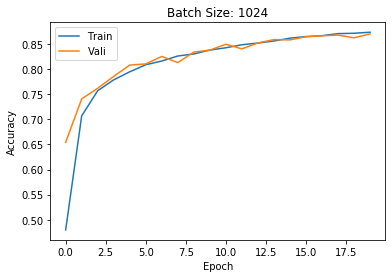

Wall time: 177 ms


In [209]:
%%time
# plot accu with epoch
plt.plot(range(epochs), accu_train_list, label="Train")
plt.plot(range(epochs), accu_vali_list, label="Vali")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Batch Size: 1024")
plt.legend()
plt.show()

In [210]:
# t = torch.cuda.get_device_properties(0).total_memory
# c = torch.cuda.memory_cached(0)
# a = torch.cuda.memory_allocated(0)
# f = c-a  # free inside cache